In [1]:
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
import seaborn as sns

In [37]:
import nltk 
from nltk.corpus import stopwords
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nnd0028\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

# 1. Data Preparation

In [19]:
legal_df = pd.read_csv('opinion_dev.csv')

In [20]:
legal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39929 entries, 0 to 39928
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   DocumentId  39929 non-null  int64 
 1   Postures    36188 non-null  object
 2   HeadText    34738 non-null  object
 3   Paragraph   39638 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.2+ MB


# 1.1 Explore missing values

<AxesSubplot:>

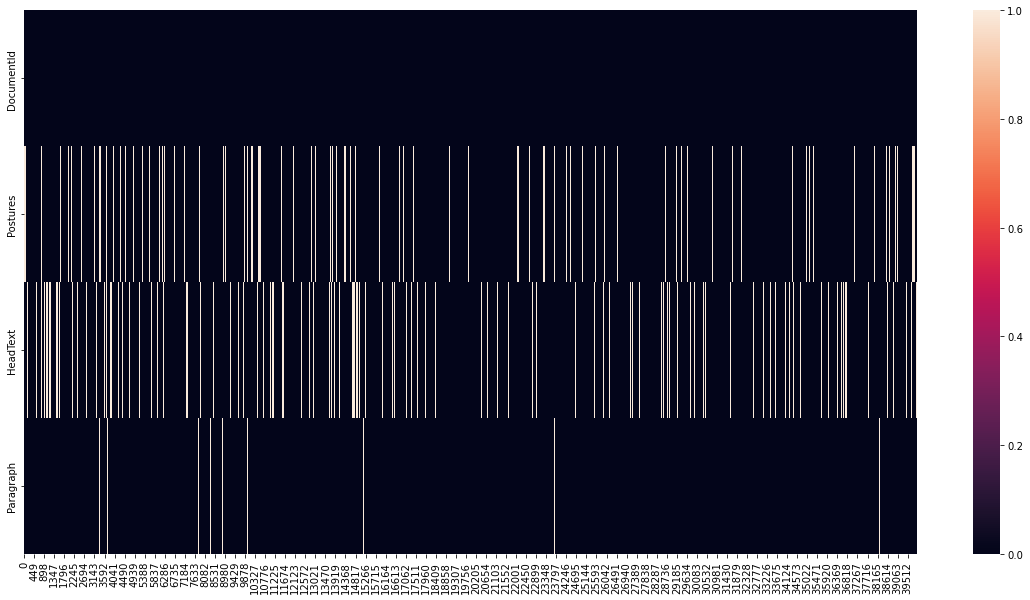

In [6]:
plt.figure(figsize = (20,10))
sns.heatmap(legal_df.isnull().transpose())

In [7]:
#Missing values at Postures Column
legal_df.Postures.isnull().value_counts()

False    36188
True      3741
Name: Postures, dtype: int64

In [8]:
# Missing values at HeadText Column
legal_df.HeadText.isnull().value_counts()

False    34738
True      5191
Name: HeadText, dtype: int64

In [9]:
#Missing Values at Paragraph column
legal_df.Paragraph.isnull().value_counts()

False    39638
True       291
Name: Paragraph, dtype: int64

There are 110 missing text at both Postures and HeadText, 45 missing text at Paragraph. Since we will analyze text at Paragraph, missing text at Paragraph is not useful for the further process. Thus we will drop the rows where Paragraph has missing values.
For missing text at HeadText, we replace 'Unknown'.

# 1.2 Explore the labels from Head Text column

In [10]:
headtext_label_w_frq = pd.DataFrame({'HeadText':legal_df.HeadText.value_counts().index, 'frequency': legal_df.HeadText.value_counts().values}, index=list(range(17473)))

In [11]:
# Filter out labels that appear more that 50 times
headtext_label_w_frq.loc[headtext_label_w_frq['frequency'] > 50, :]

,HeadText,frequency
0,conclusion,1205
1,opinion,668
2,discussion,588
3,background,530
4,ii.,500
5,i.,494
6,standard of review,468
7,i. background,456
8,analysis,429
9,iii.,366


In [21]:
# Filter the labels that appears from 10 to 50 times
headtext_label_w_frq.loc[(headtext_label_w_frq.frequency <= 50) & (headtext_label_w_frq.frequency >= 10) , :]

,HeadText,frequency
58,opinion of the court,50
59,decision,50
60,assignments of error,50
61,iv. conclusion,49
62,d.,49
...,...,...
177,ii. legal standards,10
178,a. qualifications and opinion,10
179,ii,10
180,1. applicable law,10


In [22]:
headtext_label_w_frq.loc[headtext_label_w_frq.frequency < 10,:]

,HeadText,frequency
182,ii. sufficiency of the evidence,9
183,statement of facts and procedural history,9
184,ii. procedural background,9
185,memorandum opinion and order,9
186,¶ 2 i. background,9
...,...,...
17468,4. employment records,1
17469,5. conclusion on flsa liability,1
17470,6. conclusion on rimwa liability,1
17471,a. history of barry farm,1


Overall, the most frequencies labels in Head Text column is "introduction", "conclusion", "opinion", "background", "discussion", "analysis", "standard of review", "decision", "order"...... Even though there are many other phrases that looks like different from the terms listed above, their meaning are same as these words. 

# 1.3 Remove redundant character in HeadText

In [23]:
import string
alphabet_string = string.ascii_lowercase
alphabet_lists = list(alphabet_string)

In [24]:
# Create a list of redundant characters
redundants = []
for a in alphabet_lists:
    redundants.append(a + '.')
redundants.append('.')
redundants.append('i.')
redundants.append('ii.')
redundants.append('iii.')
redundants.append('iv.')
redundants.append('v.')
redundants.append('vi.')
redundants.append('vii.')
redundants.append('viii.')
redundants.append('ix.')
redundants.append('x.')
redundants.append('i')
redundants.append('ii')
redundants.append('iii')
redundants.append('iv')
redundants.append('v')
redundants.append('vi')
redundants.append('vii')
redundants.append('viii')
redundants.append('ix')
redundants.append('x')


In [25]:
def eliminate_reduandants(text):
    try:
        tokens = nltk.word_tokenize(text, language = 'english')
        for char in redundants:     
            if char in tokens:
                tokens.remove(char)    
        label = ' '.join([str(item) for item in tokens])
    except TypeError:
        return 'N/A'
    return label


# 1.4 Grouping Head Text

In [26]:
# These are 6 main parts in a legal case
procedural_history = ['history']
facts = ['facts','fact', 'background', 'factual', 'introduction']
issues = ['issues', 'standard of reviews', 'standard of review']
rules = ['rule','rules','laws', 'law']
analysis = ['discussion', 'analysis']
order_decision = ['conclusion', 'order', 'orders', 'opinion', 'opinions'] 

In [27]:
def get_label(text):
    lowercase_text = text.lower()
    for word in procedural_history:
        if word in lowercase_text:
            return 'procedural history'
        
    for word in facts:
        #in raw headtext, there is "facts and procedural history".
        #it is clasified as "procedural history", not "facts"
        if word in lowercase_text:
            return 'facts'
       
    for word in issues:
        if word in lowercase_text:
            return 'issues'
        
    for word in rules:
        if word in lowercase_text:
            return 'rules'
        
    for word in analysis:
        if word in lowercase_text:
            return 'reasoning/analysis'
        
    for word in order_decision:
        if word in lowercase_text:
            return "oder and decision"
        else:
            return "other"
    


In [28]:
defined_labels = ['procedural history', 'facts', 'issues', 'rules', 'reasoning/analysis',"oder and decision"]

In [29]:
#Group other than "defined_labels" in to "other" group
def other_group_label(text):
    if text in defined_labels:
        return text
    else:
        return "other"

In [30]:
#Create a copy of legal dataframe
legal_df_copy = legal_df.copy()

In [38]:
#Now apply three functions above to create 6 labels
labels = []
for t in legal_df_copy['HeadText']:
    labels.append(eliminate_reduandants(t))

In [39]:
def_label = []
for l in labels:
    def_label.append(get_label(l))

In [40]:
final_labels = []
for l in def_label:
    final_labels.append(other_group_label(l))

In [43]:
series_label = pd.Series(final_labels)

In [44]:
legal_df_copy['HeadText'] = series_label

In [45]:
legal_df_copy

,DocumentId,Postures,HeadText,Paragraph
0,31944,On Appeal,other,Plaintiff Dwight Watson (“Husband”) appeals fr...
1,31944,On Appeal,facts,Husband and Wife were married in November 1989...
2,31944,On Appeal,reasoning/analysis,Husband argues that the trial court erred in v...
3,31944,On Appeal,issues,Although Husband does not clearly identify an ...
4,31944,On Appeal,other,Husband contends that the trial court’s findin...
...,...,...,...,...
39924,39930,Motion to Compel Arbitration,other,Because Romero’s STELA claim is governed by th...
39925,39931,Motion for Attorney's Fees,other,The legal question at the core of this appeal ...
39926,39932,Motion to Dismiss,other,"Order and judgment (one paper), Supreme Court,..."
39927,39933,Motion for Relief from Order or Judgment,other,U.S. Bank National Association (USBNA) appeals...


In [46]:
out_file = legal_df_copy.to_csv('cleaned_legal_case.csv',mode = 'w')

## 2. Data Exploration

In [47]:
legal_df_copy.HeadText.value_counts()

other                 28761
facts                  3245
oder and decision      2435
reasoning/analysis     2216
issues                 1322
rules                  1131
procedural history      819
Name: HeadText, dtype: int64

In [48]:
#explore the labels in dataset
legal_df_copy.HeadText.value_counts(normalize=True)

other                 0.720304
facts                 0.081269
oder and decision     0.060983
reasoning/analysis    0.055499
issues                0.033109
rules                 0.028325
procedural history    0.020511
Name: HeadText, dtype: float64